In [26]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
prostate_mutations = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_cnv = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_response = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/response_paper.csv')
prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv('/mnt/disks/pancan/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

# prostate_mutations = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
# prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_cnv = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
# prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
# prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_response = pd.read_csv('../../data/pnet_database/prostate/processed/response_paper.csv')
# prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
# prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_genes = pd.read_csv('../../data/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
# prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

prostate_cnv = prostate_cnv[prostate_genes].copy()
prostate_mutations = prostate_mutations[prostate_genes].copy()

# prostate_genes = util.select_highly_variable_genes(prostate_mutations)
# prostate_genes = prostate_genes['level_1']
prostate_mutations = prostate_mutations[list(set(prostate_mutations.columns).intersection(prostate_genes))].copy()
prostate_cnv = prostate_cnv[list(set(prostate_cnv.columns).intersection(prostate_genes))].copy()

# Regenerate input as specified in prostate_paper
prostate_mutations = (prostate_mutations > 0).astype(int)
prostate_amp = (prostate_cnv > 1).astype(int)
prostate_del = (prostate_cnv < -1).astype(int)

## Generate pnet_loader

In [28]:
genetic_data = {'mut': prostate_mutations, 'amp': prostate_amp, 'del': prostate_del}

In [29]:
import Pnet

In [30]:
test_inds = list(pd.read_csv('/mnt/disks/pancan/pnet_database/splits/test_set.csv')['id'])
train_inds = list(pd.read_csv('/mnt/disks/pancan/pnet_database/splits/training_set.csv')['id'])

In [31]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         prostate_response,
                                                                         verbose=True,
                                                                         early_stopping=False,
                                                                         train_inds=train_inds,
                                                                         test_inds=test_inds)

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (807, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
Found 4854 overlapping genes
Epoch 1 of 300
Train Loss: 0.6322175466733646
Test Loss: 0.6365092969408223
Epoch 2 of 300
Train Loss: 0.6242545764833283
Test Loss: 0.6364971235686657
Epoch 3 of 300
Train Loss: 0.6166300224105665
Test Loss: 0.6364656523162243
Epoch 4 of 300
Train Loss: 0.608358326454588
Test Loss: 0.6362550772872626
Epoch 5 of 300
Train Loss: 0.5975239598913559
Test Loss: 0.6351593428967046
Epoch 6 of 300
Train Loss: 0.5854848013195998
Test Loss: 0.6293019313438266
Epoch 7 of 300
Train Loss: 0.5733538607534718
Test Loss: 0.6095152275235045
Epoch 8 of 300
Train Loss: 0.5625927273964202
Test Loss: 0.5813326555139878
Epoch 9 of 300
Train Loss: 0.5535712378028009
Test Loss: 0.5620334101658241
Epoch 10 of 300
Train Loss

In [74]:
x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

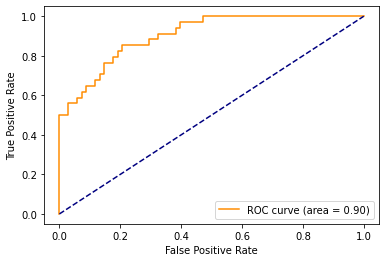

In [75]:
model.to('cpu')
pred = model(x_test, additional_test)
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_prostate_val_ROC_curve.pdf')
plt.show()

In [36]:
feature_importances, additional_importances = model.integrated_gradients(test_dataset)

In [37]:
feature_importances.sum().nlargest(20)

AR_amp         14.070674
TP53            7.135571
PTEN_del        4.943475
AR              3.591038
FNDC1           3.353137
TATDN1_amp      2.825485
GPBP1_del       2.335747
KLHDC8A_amp     2.298039
ZMIZ1_amp       2.069591
PHLDB2_del      1.786961
FAT4            1.346556
PXDNL           1.318514
ERMN            1.309563
RAB14           1.301048
ARMS2_del       1.254351
ZNF7_amp        1.237474
PCDHGB7_amp     1.234480
DIXDC1          1.229579
ARMC2_del       1.225529
TCOF1_del       1.225487
dtype: float64

In [39]:
gene_imps = model.gene_importance(test_dataset)

In [55]:
gene_imps = pd.DataFrame(gene_imps, columns=['score'])

In [57]:
gene_imps['rank'] = gene_imps.rank(ascending=False).values

In [79]:
gene_imps.nlargest(20, 'score')

,score,rank
AR,17.801615,1.0
TP53,7.249034,2.0
PTEN,5.336443,3.0
FNDC1,4.156986,4.0
TATDN1,2.829407,5.0
KLHDC8A,2.335079,6.0
GPBP1,2.326601,7.0
PHLDB2,2.314952,8.0
SLC45A4,2.150797,9.0
TCOF1,1.932698,10.0


In [69]:
layerwise_imps = model.layerwise_importance(test_dataset)

In [73]:
layerwise_imps[-2].nlargest(10)

Post-translational protein modification    10.436593
Cellular responses to stress                8.879560
RNA Polymerase II Transcription             8.792368
Signaling by GPCR                           2.458185
Adaptive Immune System                      2.212945
Innate Immune System                        1.292892
Signaling by NOTCH                          0.615791
Cytokine Signaling in Immune system         0.610979
Membrane Trafficking                        0.398084
Signaling by Receptor Tyrosine Kinases      0.311287
dtype: float32

In [66]:
gene_importances, additional_importances = model.deepLIFT(test_dataset)

/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [67]:
gene_imp_by_target = gene_importances.join(test_dataset.target).groupby('response').mean().T
gene_imp_by_target['diff'] = gene_imp_by_target[0] - gene_imp_by_target[1]

In [68]:
gene_imp_by_target[abs(gene_imp_by_target['diff']) > 0].nlargest(10, 'diff')

response,0,1,diff
CAPN1_cnv,0.005280,-0.004887,0.010167
PTEN_cnv,0.026148,0.016268,0.009880
TSC2_cnv,0.009099,0.001389,0.007710
AXIN1_cnv,0.008263,0.003457,0.004806
ATG9A_cnv,0.000970,-0.003023,0.003993
HSPG2_cnv,0.004866,0.000956,0.003910
RNF216_cnv,0.009824,0.005976,0.003848
RELA_cnv,0.003983,0.000354,0.003629
PABPC1_cnv,0.007784,0.004853,0.002931
CACNB2_cnv,0.004240,0.001394,0.002846


In [69]:
gene_importances.mean().nlargest(20)

PTEN_cnv      0.023050
APC_cnv       0.008939
RNF216_cnv    0.008617
PRKDC_cnv     0.008205
TP53          0.008077
TAF2_cnv      0.007738
PABPC1_cnv    0.006865
AXIN1_cnv     0.006756
AR_cnv        0.006717
TSC2_cnv      0.006682
CUL1_cnv      0.005403
PIK3CA_cnv    0.004455
MCM3_cnv      0.004396
LMNA_cnv      0.004286
PKP1_cnv      0.004271
NFKB1_cnv     0.004243
RPL10A_cnv    0.003842
EXOC3_cnv     0.003794
AR            0.003660
HSPG2_cnv     0.003640
dtype: float32

In [70]:
pathway_importances = model.layerwise_importance(test_dataset)

In [71]:
pathway_importances[-1].nlargest(10, 1)

response,0,1,diff
Cellular responses to external stimuli,0.000915,0.039004,0.038090
Metabolism of proteins,0.012012,0.022608,0.010596
Developmental Biology,0.010936,0.020486,0.009550
Signal Transduction,0.008149,0.018378,0.010229
DNA Repair,0.011632,0.014196,0.002564
Extracellular matrix organization,0.006617,0.012103,0.005486
Sensory Perception,0.000937,0.010962,0.010025
Hemostasis,0.008317,0.010942,0.002625
Circadian Clock,0.004463,0.005404,0.000941
Reproduction,0.001725,0.005254,0.003529


In [72]:
pathway_importances[-2].nlargest(10, 1)

response,0,1,diff
Cellular responses to stress,0.001299,0.052735,0.051436
Post-translational protein modification,0.006333,0.013758,0.007425
DNA Double-Strand Break Repair,0.012975,0.013450,0.000475
Keratinization,0.004650,0.012441,0.007792
Signaling by WNT,0.005216,0.008919,0.003703
Transcriptional regulation of white adipocyte differentiation,0.004768,0.008667,0.003899
Sensory processing of sound,0.004133,0.006763,0.002630
Membrane Trafficking,0.003062,0.006256,0.003194
Translation,0.005887,0.006060,0.000173
DNA Replication Pre-Initiation,0.004728,0.005986,0.001259


In [73]:
pathway_importances[-3].nlargest(10, 1)

response,0,1,diff
HSP90 chaperone cycle for steroid hormone receptors (SHR),0.002474,0.108070,0.105596
Formation of the cornified envelope,0.008502,0.023476,0.014974
Generic Transcription Pathway,0.004554,0.020308,0.015753
Synthesis of IP3 and IP4 in the cytosol,0.008836,0.013263,0.004426
Nonhomologous End-Joining (NHEJ),0.013090,0.013193,0.000102
TCF dependent signaling in response to WNT,0.006543,0.012161,0.005618
Deubiquitination,0.004175,0.009546,0.005370
Sensory processing of sound by inner hair cells of the cochlea,0.006128,0.008335,0.002207
PIP3 activates AKT signaling,0.005060,0.008203,0.003144
Meiotic synapsis,0.002122,0.008032,0.005910


In [74]:
pathway_importances[-4].nlargest(10, 1)

response,0,1,diff
SUMO E3 ligases SUMOylate target proteins,0.000713,0.030479,0.029766
Nuclear Receptor transcription pathway,0.000429,0.026512,0.026083
Ub-specific processing proteases,0.007281,0.026179,0.018898
Negative regulation of the PI3K/AKT network,0.007124,0.012737,0.005613
Estrogen-dependent gene expression,0.005299,0.012335,0.007036
PTEN Loss of Function in Cancer,0.004559,0.009883,0.005324
Ovarian tumor domain proteases,0.003851,0.008306,0.004454
Disassembly of the destruction complex and recruitment of AXIN to the membrane,0.002925,0.007686,0.004761
Deactivation of the beta-catenin transactivating complex,0.003794,0.007482,0.003688
Downstream TCR signaling,0.007424,0.007151,0.000273


In [75]:
pathway_importances[-5].nlargest(10, 1)

IndexError: list index out of range

In [ ]:
pathway_importances[-6].nlargest(10, 1)

In [ ]:
pathway_importances[-7].nlargest(10, 1)

In [ ]:
pathway_importances[-8].nlargest(10, 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))

In [ ]:
test_acc = sum(clf.predict(test_dataset.input_df.values) == test_dataset.target.values.reshape(-1))/len(test_dataset)
test_acc

In [ ]:
pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns).nlargest(10, 0)